In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Set up the notebook environment
!pip install catboost xgboost lightgbm scikit-learn tensorflow scikeras
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io
import scipy
from scipy import stats
from scipy.stats import pearsonr
from scipy import signal as sig
from scipy.signal import butter, filtfilt, welch, decimate
from scipy.stats import skew, kurtosis
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.


### Tuning Coefficients Here:

In [ ]:
#best parameter - 4.17
#window and step sizes - 0.4855
model_window_length = 100
model_step_size = 30

#hyperparameters
cat_iterations = 500
cat_depth = 5
cat_learning_rate = 0.05
cat_l2_leaf_reg = 4

In [ ]:
#window and step sizes
model_window_length = 100
model_step_size = 30

#hyperparameters
cat_iterations = 500
cat_depth = 5
cat_learning_rate = 0.05
cat_l2_leaf_reg = 4

---

In [ ]:
data_train = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/raw_training_data.mat')
data_leader = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/leaderboard_data.mat')

In [ ]:
data_new_1 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub1_comp.mat')
data_new_2 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub2_comp.mat')
data_new_3 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub3_comp.mat')

In [ ]:
data_lbl_1 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub1_testlabels.mat')
data_lbl_2 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub2_testlabels.mat')
data_lbl_3 = scipy.io.loadmat('/content/drive/Shareddrives/BE 5210 Shared Drive/Ted Yang/final_project_part_2_3.0/sub3_testlabels.mat')

In [ ]:
len(data_lbl_1['test_dg'])
len(data_new_1['test_data'])

200000

In [ ]:
data_glove_n1 = data_new_1['train_dg']
data_ecog_n1 = data_new_1['train_data']

data_glove_n2 = data_new_2['train_dg']
data_ecog_n2 = data_new_2['train_data']

data_glove_n3 = data_new_3['train_dg']
data_ecog_n3 = data_new_3['train_data']

data_ecog_n1, data_ecog_n2, data_ecog_n3

(array([[  193,  -491, -4293, ...,  1827,  3096,  2395],
        [   96,  -451, -4419, ...,  1794,  3120,  2497],
        [  329,  -272, -4380, ...,  1668,  3236,  2569],
        ...,
        [ 1047,  -588,  1257, ...,  3559,  2951,  1856],
        [  841,  -834,   962, ...,  3342,  2703,  2135],
        [  672, -1009,   563, ...,  3131,  2515,  2187]], dtype=int32),
 array([[ -872,   164,   609, ..., -2776, -7720,   -96],
        [-1191,   -78,   454, ..., -2787, -7544,  -188],
        [-1507,  -395,   204, ..., -2871, -7425,  -418],
        ...,
        [ 1357,  3948,   837, ...,  1711,  1615, -1276],
        [ 1491,  4032,   906, ...,  1710,  1662, -1235],
        [ 1774,  4067,   988, ...,  1684,  1637, -1150]], dtype=int32),
 array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
        [  842,  1850,  1461, ...,  -897,  -385, -1558],
        [  582,  1912,  1505, ...,  -549,  -391, -1414],
        ...,
        [  309,  2077,   492, ...,   402,   852,  1240],
        [   45,  19

In [ ]:
len(data_ecog_n1)

400000

* Data Structure
* 6min, 40s, 400,000 samples, 1000Hz

In [ ]:
data_leader = data_leader['leaderboard_ecog']

In [ ]:
lead1 = data_leader[0]
lead2 = data_leader[1]
lead3 = data_leader[2]

len(lead1[0])

147500

In [ ]:
data_glove = data_train['train_dg']
data_ecog = data_train['train_ecog']
train_dg = []
test_dg = []
train_ecog = []
test_ecog = []

# Define the split ratio (e.g., 70% for training and 30% for testing)
split_ratio = 0.7

# Function to split each subject's data
def split_data(data, split_ratio):
    num_samples = len(data[0])
    split_point = int(num_samples * split_ratio)
    train = data[0][:split_point]
    test = data[0][split_point:]
    return train, test

# Loop over each subject's data for glove and ECoG data
for glove_data, ecog_data in zip(data_glove, data_ecog):
    train_dg_split, test_dg_split = split_data(glove_data, split_ratio)
    train_ecog_split, test_ecog_split = split_data(ecog_data, split_ratio)

    # Append the split data to their respective lists
    train_dg.append(train_dg_split)
    test_dg.append(test_dg_split)
    train_ecog.append(train_ecog_split)
    test_ecog.append(test_ecog_split)

# Now train_dg, test_dg, train_ecog, and test_ecog contain the split data for each subject

#training set
total_samples_train_ecog = len(train_ecog[0])

#testing set
total_samples_test_ecog = len(test_ecog[0])

#full dataset sample before the split
total_samples_full_ecog = total_samples_train_ecog + total_samples_test_ecog

print(f'The total number of samples is {total_samples_full_ecog}.')
print(f'The number of samples in the training set is {total_samples_train_ecog}.')
print(f'The number of samples in the testing set is {total_samples_test_ecog}.')

The total number of samples is 300000.
The number of samples in the training set is 210000.
The number of samples in the testing set is 90000.


In [ ]:
def filter_data(raw_eeg, fs=1000):
    """
    Input:
      raw_eeg (samples x channels): the raw signal
      fs: the sampling rate (1000 for this dataset)

    Output:
      clean_data (samples x channels): the filtered signal
    """

    #lowcut and highcut for the bandpass filter
    lowcut = 0.15
    highcut = 200.0

    #Butterworth bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(4, [low, high], btype='band', analog=False)

    #apply filter to raw ECoG data
    clean_data = filtfilt(b, a, raw_eeg, axis=0)

    return clean_data


In [ ]:
#window and step sizes
window_length = model_window_length
step_size = model_step_size

#number of feature windows M for the full dataset, training, and testing sets
M_full = 1 + (total_samples_full_ecog - window_length) // step_size
M_train = 1 + (total_samples_train_ecog - window_length) // step_size
M_test = 1 + (total_samples_test_ecog - window_length) // step_size

print(f'There are {M_full} windows using all the data.')
print(f'There are {M_train} windows training data.')
print(f'There are {M_test} windows testing data.')

# **Feature Extraction**

In [ ]:
"""#This one has got 0.4426 for testing set

def get_features(filtered_window, fs=1000):

    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate

    Output:
        features (channels x num_features): the features calculated on each channel for the window

    # Make sure nperseg does not exceed window size
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential

    # Compute the Power Spectral Density (PSD) for each channel
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        #'beta': (13, 30),
        #'theta': (4, 7),  # Adding an extra band as an example
        #'low_gamma': (30, 50),  # Another example band
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Initialize a dictionary to hold the power for each band
    band_powers = {band: np.zeros(psd.shape[0]) for band in bands}

    # Calculate power for each band
    for band, (low, high) in bands.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.sum(psd[:, freq_mask], axis=1)

    # Collect all features
    all_features = [mean, variance, lmp] + list(band_powers.values())
    features = np.vstack(all_features).T

    return features
"""

"#This one has got 0.4426 for testing set\n\ndef get_features(filtered_window, fs=1000):\n\n    Inputs:\n        filtered_window (window_samples x channels): the window of the filtered ECoG signal\n        fs: sampling rate\n\n    Output:\n        features (channels x num_features): the features calculated on each channel for the window\n\n    # Make sure nperseg does not exceed window size\n    nperseg = min(filtered_window.shape[0], 256)\n\n    # Basic statistical features\n    mean = np.mean(filtered_window, axis=0)\n    variance = np.var(filtered_window, axis=0)\n    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential\n\n    # Compute the Power Spectral Density (PSD) for each channel\n    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)\n\n    # Define frequency bands\n    bands = {\n        'alpha': (8, 12),\n        #'beta': (13, 30),\n        #'theta': (4, 7),  # Adding an extra band as an example\n        #'low_gamma': (30, 50),  # Another example 

In [ ]:
#This one has got 0.4645 for testing set
def get_features(filtered_window, fs=1000):
    """
    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate

    Output:
        features (channels x num_features): the features calculated on each channel for the window
    """
    # Make sure nperseg does not exceed window size
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential

    # Compute the Power Spectral Density (PSD) for each channel
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        #'beta': (13, 30),
        'theta': (4, 7),  # Adding an extra band as an example
        #'low_gamma': (30, 50),  # Another example band
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Initialize a dictionary to hold the power for each band
    band_powers = {band: np.zeros(psd.shape[0]) for band in bands}

    # Calculate power for each band
    for band, (low, high) in bands.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.sum(psd[:, freq_mask], axis=1)

    # Collect all features
    all_features = [mean, variance, lmp] + list(band_powers.values())
    features = np.vstack(all_features).T

    return features

In [ ]:
#This one has got 0.4855 for testing set
def get_features(filtered_window, fs=1000):
    """
    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate

    Output:
        features (channels x num_features): the features calculated on each channel for the window
    """
    # Make sure nperseg does not exceed window size
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential
    skewness = skew(filtered_window, axis=0)
    kurt = kurtosis(filtered_window, axis=0)
    ptp_amp = np.ptp(filtered_window, axis=0)  # Peak-to-peak amplitude

    # Compute the Power Spectral Density (PSD) for each channel
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        'theta': (4, 7),
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Initialize a dictionary to hold the power for each band
    band_powers = {band: np.zeros(psd.shape[0]) for band in bands}

    # Calculate power for each band
    for band, (low, high) in bands.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.sum(psd[:, freq_mask], axis=1)

    # Collect all features into a list
    all_features = [mean, variance, lmp, skewness, kurt, ptp_amp] + list(band_powers.values())

    # Stack features vertically and transpose to get (channels x num_features)
    features = np.vstack(all_features).T

    return features

In [ ]:
"""def get_features(filtered_window, fs=1000):

    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate

    Output:
        features (channels x num_features): the features calculated on each channel for the window

    # Make sure nperseg does not exceed window size
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    std_dev = np.sqrt(variance)  # Standard deviation as a measure of volatility
    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential
    skewness = skew(filtered_window, axis=0)
    kurt = kurtosis(filtered_window, axis=0)
    ptp_amp = np.ptp(filtered_window, axis=0)  # Peak-to-peak amplitude

    # Variance over specific initial windows
    var_10 = np.var(filtered_window[:10, :], axis=0) if filtered_window.shape[0] >= 10 else np.zeros_like(variance)
    var_20 = np.var(filtered_window[:20, :], axis=0) if filtered_window.shape[0] >= 20 else np.zeros_like(variance)
    var_30 = np.var(filtered_window[:30, :], axis=0) if filtered_window.shape[0] >= 30 else np.zeros_like(variance)
    var_40 = np.var(filtered_window[:40, :], axis=0) if filtered_window.shape[0] >= 40 else np.zeros_like(variance)
    var_50 = np.var(filtered_window[:50, :], axis=0) if filtered_window.shape[0] >= 50 else np.zeros_like(variance)

    # Compute the Power Spectral Density (PSD) for each channel
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        'theta': (4, 7),
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Initialize a dictionary to hold the power for each band
    band_powers = {band: np.zeros(psd.shape[0]) for band in bands}

    # Calculate power for each band
    for band, (low, high) in bands.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.sum(psd[:, freq_mask], axis=1)

    # Collect all features into a list
    all_features = [mean, variance, std_dev, lmp, skewness, kurt, ptp_amp,
                    var_10, var_20, var_30, var_40, var_50] + list(band_powers.values())

    # Stack features vertically and transpose to get (channels x num_features)
    features = np.vstack(all_features).T

    return features"""

"def get_features(filtered_window, fs=1000):\n\n    Inputs:\n        filtered_window (window_samples x channels): the window of the filtered ECoG signal\n        fs: sampling rate\n\n    Output:\n        features (channels x num_features): the features calculated on each channel for the window\n\n    # Make sure nperseg does not exceed window size\n    nperseg = min(filtered_window.shape[0], 256)\n\n    # Basic statistical features\n    mean = np.mean(filtered_window, axis=0)\n    variance = np.var(filtered_window, axis=0)\n    std_dev = np.sqrt(variance)  # Standard deviation as a measure of volatility\n    lmp = np.mean(np.abs(filtered_window), axis=0)  # Local Motor Potential\n    skewness = skew(filtered_window, axis=0)\n    kurt = kurtosis(filtered_window, axis=0)\n    ptp_amp = np.ptp(filtered_window, axis=0)  # Peak-to-peak amplitude\n\n    # Variance over specific initial windows\n    var_10 = np.var(filtered_window[:10, :], axis=0) if filtered_window.shape[0] >= 10 else np.zer

In [ ]:
"""def get_features(filtered_window, fs=1000, window_size=20):

    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate
        window_size: window size for moving average and standard deviation

    Output:
        features (channels x num_features): the features calculated on each channel for the window

    # Make sure nperseg does not exceed window size
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    std_dev = np.sqrt(variance)
    lmp = np.mean(np.abs(filtered_window), axis=0)
    skewness = skew(filtered_window, axis=0)
    kurt = kurtosis(filtered_window, axis=0)
    ptp_amp = np.ptp(filtered_window, axis=0)

    # Compute moving averages and standard deviations for Bollinger Bands
    if filtered_window.shape[0] >= window_size:
        rolling_mean = np.mean(filtered_window[-window_size:], axis=0)
        rolling_std = np.std(filtered_window[-window_size:], axis=0)
        bollinger_upper = rolling_mean + 2 * rolling_std
        bollinger_lower = rolling_mean - 2 * rolling_std
    else:
        # Default to zero if not enough data for rolling calculation
        bollinger_upper = np.zeros_like(mean)
        bollinger_lower = np.zeros_like(mean)

    # Compute the Power Spectral Density (PSD)
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        'theta': (4, 7),
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Calculate power for each band
    band_powers = {band: np.zeros(psd.shape[0]) for band in bands}
    for band, (low, high) in bands.items():
        freq_mask = (freqs >= low) & (freqs <= high)
        band_powers[band] = np.sum(psd[:, freq_mask], axis=1)

    # Collect all features into a list
    all_features = [mean, variance, std_dev, lmp, skewness, kurt, ptp_amp,
                    bollinger_upper, bollinger_lower] + list(band_powers.values())

    # Stack features vertically and transpose to get (channels x num_features)
    features = np.vstack(all_features).T

    return features"""

"def get_features(filtered_window, fs=1000, window_size=20):\n\n    Inputs:\n        filtered_window (window_samples x channels): the window of the filtered ECoG signal\n        fs: sampling rate\n        window_size: window size for moving average and standard deviation\n\n    Output:\n        features (channels x num_features): the features calculated on each channel for the window\n\n    # Make sure nperseg does not exceed window size\n    nperseg = min(filtered_window.shape[0], 256)\n\n    # Basic statistical features\n    mean = np.mean(filtered_window, axis=0)\n    variance = np.var(filtered_window, axis=0)\n    std_dev = np.sqrt(variance)\n    lmp = np.mean(np.abs(filtered_window), axis=0)\n    skewness = skew(filtered_window, axis=0)\n    kurt = kurtosis(filtered_window, axis=0)\n    ptp_amp = np.ptp(filtered_window, axis=0)\n\n    # Compute moving averages and standard deviations for Bollinger Bands\n    if filtered_window.shape[0] >= window_size:\n        rolling_mean = np.me

In [ ]:
"""def get_features(filtered_window, fs=1000, window_size=20):

    Inputs:
        filtered_window (window_samples x channels): the window of the filtered ECoG signal
        fs: sampling rate
        window_size: window size for moving average and standard deviation, used for Bollinger Bands

    Output:
        features (channels x num_features): the features calculated on each channel for the window

    # Ensure nperseg does not exceed window size, used for PSD calculation
    nperseg = min(filtered_window.shape[0], 256)

    # Basic statistical features
    mean = np.mean(filtered_window, axis=0)
    variance = np.var(filtered_window, axis=0)
    std_dev = np.sqrt(variance)
    lmp = np.mean(np.abs(filtered_window), axis=0)
    skewness = skew(filtered_window, axis=0)
    kurt = kurtosis(filtered_window, axis=0)
    ptp_amp = np.ptp(filtered_window, axis=0)

    # Variance over specific initial windows
    var_windows = [10, 20, 30, 40, 50]
    var_features = [np.var(filtered_window[:w, :], axis=0) if filtered_window.shape[0] >= w else np.zeros_like(variance) for w in var_windows]

    # Bollinger Bands
    if filtered_window.shape[0] >= window_size:
        rolling_mean = np.mean(filtered_window[-window_size:], axis=0)
        rolling_std = np.std(filtered_window[-window_size:], axis=0)
        bollinger_upper = rolling_mean + 2 * rolling_std
        bollinger_lower = rolling_mean - 2 * rolling_std
    else:
        bollinger_upper = np.zeros_like(mean)
        bollinger_lower = np.zeros_like(mean)

    # Compute the Power Spectral Density (PSD) for each channel
    freqs, psd = welch(filtered_window.T, fs, nperseg=nperseg)

    # Define frequency bands
    bands = {
        'alpha': (8, 12),
        'theta': (4, 7),
        'custom_band1': (18, 24),
        'custom_band2': (75, 115),
        'custom_band3': (125, 159),
        'custom_band4': (159, 175)
    }

    # Calculate power for each band
    band_powers = {band: np.sum(psd[:, (freqs >= low) & (freqs <= high)], axis=1) for band, (low, high) in bands.items()}

    # Collect all features into a list
    all_features = [mean, variance, std_dev, lmp, skewness, kurt, ptp_amp,
                    bollinger_upper, bollinger_lower] + var_features + list(band_powers.values())

    # Stack features vertically and transpose to get (channels x num_features)
    features = np.vstack(all_features).T

    return features"""

"def get_features(filtered_window, fs=1000, window_size=20):\n\n    Inputs:\n        filtered_window (window_samples x channels): the window of the filtered ECoG signal\n        fs: sampling rate\n        window_size: window size for moving average and standard deviation, used for Bollinger Bands\n\n    Output:\n        features (channels x num_features): the features calculated on each channel for the window\n\n    # Ensure nperseg does not exceed window size, used for PSD calculation\n    nperseg = min(filtered_window.shape[0], 256)\n\n    # Basic statistical features\n    mean = np.mean(filtered_window, axis=0)\n    variance = np.var(filtered_window, axis=0)\n    std_dev = np.sqrt(variance)\n    lmp = np.mean(np.abs(filtered_window), axis=0)\n    skewness = skew(filtered_window, axis=0)\n    kurt = kurtosis(filtered_window, axis=0)\n    ptp_amp = np.ptp(filtered_window, axis=0)\n\n    # Variance over specific initial windows\n    var_windows = [10, 20, 30, 40, 50]\n    var_features 



---




In [ ]:
def get_windowed_feats(raw_ecog, fs, window_length_ms, window_overlap_ms):
    """
    Inputs:
        raw_ecog (samples x channels): the raw signal
        fs: the sampling rate (1000 for this dataset)
        window_length_ms: the window's length in milliseconds
        window_overlap_ms: the window's overlap in milliseconds

    Output:
        all_feats (num_windows x (channels x features)): the features for each channel for each time window
    """
    window_length = int(fs * (window_length_ms / 1000))
    window_overlap = int(fs * (window_overlap_ms / 1000))
    step_size = window_length - window_overlap

    #filter_data function placeholder
    filtered_ecog = raw_ecog

    total_samples = raw_ecog.shape[0]
    num_windows = 1 + (total_samples - window_length) // step_size

    feature_list = []

    for start_idx in tqdm(range(0, total_samples - window_length + 1, step_size)):
        end_idx = start_idx + window_length
        window = filtered_ecog[start_idx:end_idx, :]

        #features for this window
        window_features = get_features(window, fs)

        #append features to list
        feature_list.append(window_features.flatten())

    #stack to get 2D array (num_windows x features)
    all_feats = np.array(feature_list)

    return all_feats

In [ ]:
def create_R_matrix(features, N=3):
    """
    Input:
        features: The 2D array of features (num_windows x num_features_per_window).
        N: The number of previous windows to include for each prediction instance.

    Output:
        R: The response matrix.
    """
    #first N-1 rows to beginning of features matrix
    adjusted_features = np.vstack([features[:N-1], features])

    #number of total instances after adjustment
    M_prime = adjusted_features.shape[0] - (N - 1)

    #initialize response matrix R
    num_features = features.shape[1]
    R = np.zeros((M_prime, N * num_features + 1))  # +1 for the intercept term

    #fill in R
    for i in range(M_prime):
        #extract N consecutive windows of features
        consecutive_features = adjusted_features[i:i+N].flatten()
        #fill corresponding row in R, adding 1 as the last column
        R[i, 1:] = consecutive_features
        R[i, 0] = 1  # Intercept term

    return R

In [ ]:
train_ecog_1 = train_ecog[0]
train_ecog_2 = train_ecog[1]
train_ecog_3 = train_ecog[2]

train_glove_1 = train_dg[0]
train_glove_2 = train_dg[1]
train_glove_3 = train_dg[2]

## **MORE DATA**

In [ ]:
train_ecog_1 = np.concatenate((train_ecog_1, data_ecog_n1), axis=0)
train_ecog_2 = np.concatenate((train_ecog_2, data_ecog_n2), axis=0)
train_ecog_3 = np.concatenate((train_ecog_3, data_ecog_n3), axis=0)

train_glove_1 = np.concatenate((train_glove_1, data_glove_n1), axis=0)
train_glove_2 = np.concatenate((train_glove_2, data_glove_n2), axis=0)
train_glove_3 = np.concatenate((train_glove_3, data_glove_n3), axis=0)

In [ ]:
#feature extraction for each subject
feature_1 = get_windowed_feats(train_ecog_1, 1000, model_window_length, model_step_size)
feature_2 = get_windowed_feats(train_ecog_2, 1000, model_window_length, model_step_size)
feature_3 = get_windowed_feats(train_ecog_3, 1000, model_window_length, model_step_size)

num_target_windows = feature_1.shape[0]
num_target_windows

100%|██████████| 8713/8713 [00:07<00:00, 1235.87it/s]


8713

In [ ]:
#get R matrix
R_1 = create_R_matrix(feature_1, N=3)
R_2 = create_R_matrix(feature_2, N=3)
R_3 = create_R_matrix(feature_3, N=3)

In [ ]:
def get_windowed_target(glove_data, window_length_ms, window_overlap_ms, fs=1000):
    window_length = int(fs * (window_length_ms / 1000))
    window_overlap = int(fs * (window_overlap_ms / 1000))
    step_size = window_length - window_overlap

    num_windows = 1 + (glove_data.shape[0] - window_length) // step_size
    targets = []

    for start_idx in range(0, glove_data.shape[0] - window_length + 1, step_size):
        end_idx = start_idx + window_length
        window = glove_data[start_idx:end_idx, :]
        targets.append(np.mean(window, axis=0))  # Example: mean over the window

    return np.array(targets)

In [ ]:
# Windowing target glove data
target_1 = get_windowed_target(train_glove_1, model_window_length, model_step_size)
target_2 = get_windowed_target(train_glove_2, model_window_length, model_step_size)
target_3 = get_windowed_target(train_glove_3, model_window_length, model_step_size)

In [ ]:
"""# Define parameter distributions for CatBoost
cat_params = {
    'iterations': np.arange(500, 800, 50),
    'depth': np.arange(3, 7, 1),
    'learning_rate': np.linspace(0.01, 0.3, 5),
    'l2_leaf_reg': np.linspace(1, 10, 5)
}


# Function to setup and run Randomized Search CV
def optimize_and_train_model(X, y, params, n_iter=100, cv=3):
    model = CatBoostRegressor(loss_function='MultiRMSE', verbose=False)
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

# Datasets
datasets = [(R_1[:, 1:], target_1), (R_2[:, 1:], target_2), (R_3[:, 1:], target_3)]

# Optimize and train each model
best_models = []
for i, (X, y) in tqdm(enumerate(datasets, start=1)):
    print(f"Optimizing and training model for Dataset {i}")
    best_model, best_params, best_score = optimize_and_train_model(X, y, cat_params)
    best_models.append(best_model)
    print(f"Best parameters for Dataset {i}: {best_params}")
    print(f"Best score for Dataset {i}: {best_score}")"""

'# Define parameter distributions for CatBoost\ncat_params = {\n    \'iterations\': np.arange(500, 800, 50),\n    \'depth\': np.arange(3, 7, 1),\n    \'learning_rate\': np.linspace(0.01, 0.3, 5),\n    \'l2_leaf_reg\': np.linspace(1, 10, 5)\n}\n\n\n# Function to setup and run Randomized Search CV\ndef optimize_and_train_model(X, y, params, n_iter=100, cv=3):\n    model = CatBoostRegressor(loss_function=\'MultiRMSE\', verbose=False)\n    random_search = RandomizedSearchCV(\n        model,\n        param_distributions=params,\n        n_iter=n_iter,\n        scoring=\'neg_mean_squared_error\',\n        cv=cv,\n        verbose=1,\n        random_state=42,\n        n_jobs=-1\n    )\n    random_search.fit(X, y)\n    return random_search.best_estimator_, random_search.best_params_, random_search.best_score_\n\n# Datasets\ndatasets = [(R_1[:, 1:], target_1), (R_2[:, 1:], target_2), (R_3[:, 1:], target_3)]\n\n# Optimize and train each model\nbest_models = []\nfor i, (X, y) in tqdm(enumerate(dat

In [ ]:
# XGBoost Model
"""xgb_model1 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
xgb_model1.fit(R_1[:, 1:], target_1)

xgb_model2 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
xgb_model2.fit(R_2[:, 1:], target_2)

xgb_model3 = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1)
xgb_model3.fit(R_3[:, 1:], target_3)
"""
# CatBoost Model
cat_model1 = CatBoostRegressor(iterations=cat_iterations, depth=cat_depth, learning_rate=cat_learning_rate, l2_leaf_reg=cat_l2_leaf_reg, loss_function='MultiRMSE', verbose=False)
cat_model1.fit(R_1[:, 1:], target_1)

cat_model2 = CatBoostRegressor(iterations=cat_iterations, depth=cat_depth, learning_rate=cat_learning_rate, l2_leaf_reg=cat_l2_leaf_reg, loss_function='MultiRMSE', verbose=False)
cat_model2.fit(R_2[:, 1:], target_2)

cat_model3 = CatBoostRegressor(iterations=cat_iterations, depth=cat_depth, learning_rate=cat_learning_rate, l2_leaf_reg=cat_l2_leaf_reg, loss_function='MultiRMSE', verbose=False)
cat_model3.fit(R_3[:, 1:], target_3)

----> Test

In [ ]:
def linear_filter(R_matrix, train_data, lambda_reg=0.01):
    num_samples_features = R_matrix.shape[0]
    num_samples_flexion = train_data.shape[0]

    # Downsample train_data if it doesn't match the number of feature windows in R_matrix
    if num_samples_features != num_samples_flexion:
        downsample_factor = num_samples_flexion // num_samples_features
        downsample_factor = max(downsample_factor, 1)  # Ensure downsample_factor at least 1
        downsize_data = decimate(train_data, downsample_factor, axis=0)

        # Ensure downsize_data has same number of samples as R_matrix
        if downsize_data.shape[0] > num_samples_features:
            downsize_data = downsize_data[:num_samples_features]
    else:
        downsize_data = train_data

    # Regularized linear filter f using matrix multiplication
    # p1 = (R^T R + lambda * I)^(-1)
    lambda_identity = lambda_reg * np.eye(R_matrix.shape[1])  # Lambda times identity matrix
    p1 = np.linalg.inv(np.matmul(R_matrix.T, R_matrix) + lambda_identity)

    # p2 = R^T Y
    p2 = np.matmul(R_matrix.T, downsize_data)

    # f = p1 * p2
    lf = np.matmul(p1, p2)

    return downsize_data, lf

In [ ]:
#assign test ecog & glove data
test_ecog_1 = test_ecog[0]
test_ecog_2 = test_ecog[1]
test_ecog_3 = test_ecog[2]

test_glove_1 = test_dg[0]
test_glove_2 = test_dg[1]
test_glove_3 = test_dg[2]

In [ ]:
#feature extraction of test set
test_feature_1 = get_windowed_feats(test_ecog_1, 1000, model_window_length, model_step_size)
test_feature_2 = get_windowed_feats(test_ecog_2, 1000, model_window_length, model_step_size)
test_feature_3 = get_windowed_feats(test_ecog_3, 1000, model_window_length, model_step_size)

100%|██████████| 1285/1285 [00:01<00:00, 1128.09it/s]


In [ ]:
#R matrix for test set
test_R_1 = create_R_matrix(test_feature_1, N=3)
test_R_2 = create_R_matrix(test_feature_2, N=3)
test_R_3 = create_R_matrix(test_feature_3, N=3)

In [ ]:
"""xgb_preds_1 = xgb_model1.predict(test_R_1[:, 1:])
xgb_preds_2 = xgb_model2.predict(test_R_2[:, 1:])
xgb_preds_3 = xgb_model3.predict(test_R_3[:, 1:])
"""
cat_preds_1 = cat_model1.predict(test_R_1[:, 1:])
cat_preds_2 = cat_model2.predict(test_R_2[:, 1:])
cat_preds_3 = cat_model3.predict(test_R_3[:, 1:])

In [ ]:
#linear filter
test_glove_ds_1, tf_1 = linear_filter(test_R_1, test_glove_1)
test_glove_ds_2, tf_2 = linear_filter(test_R_2, test_glove_2)
test_glove_ds_3, tf_3 = linear_filter(test_R_3, test_glove_3)

In [ ]:
#generate prediction of linear f
y_pred_1 = np.dot(test_R_1, tf_1)
y_pred_2 = np.dot(test_R_2, tf_2)
y_pred_3 = np.dot(test_R_3, tf_3)

In [ ]:
#correlation using pearsonr
def calculate_correlations(y_true, y_pred):
    correlations = []
    for finger in range(y_true.shape[1]):  # Assuming y_true.shape[1] is the number of fingers
        corr, _ = pearsonr(y_true[:, finger], y_pred[:, finger])
        correlations.append(corr)
    return correlations

In [ ]:
#correlations
"""correlations_xgb_1 = calculate_correlations(test_glove_ds_1, xgb_preds_1)
correlations_xgb_2 = calculate_correlations(test_glove_ds_2, xgb_preds_2)
correlations_xgb_3 = calculate_correlations(test_glove_ds_3, xgb_preds_3)"""

correlations_cat_1 = calculate_correlations(test_glove_ds_1, cat_preds_1)
correlations_cat_2 = calculate_correlations(test_glove_ds_2, cat_preds_2)
correlations_cat_3 = calculate_correlations(test_glove_ds_3, cat_preds_3)

In [ ]:
#create function for correlation
def cor(test_data, f, R_matrix):
    """
    Calculates Pearson correlation coefficients between true and predicted finger angles.

    Parameters:
    - test_data: The actual finger flexion data for the test set (samples x fingers).
    - f: The linear filter coefficients (features x fingers) calculated from the training set.
    - R_matrix: The feature matrix from the test ECoG data (samples x features).

    Returns:
    - A list of Pearson correlation coefficients, one for each finger.
    """
    #predict finger angles
    predicted = np.dot(R_matrix, f)

    #make sure predicted data has same shape as test data
    assert predicted.shape == test_data.shape, "Shape mismatch between predicted and true data"

    #Pearson correlation for each finger
    subject_correlations = []
    for finger in range(test_data.shape[1]):
        true_angle = test_data[:, finger]
        predicted_angle = predicted[:, finger]

        #correlation
        correlation = np.corrcoef(true_angle, predicted_angle)[0, 1]

        #append correlation coefficient
        subject_correlations.append(correlation)

    return subject_correlations

In [ ]:
#downsample glove data
train_glove_ds_1, f_1 = linear_filter(R_1, train_glove_1)
train_glove_ds_2, f_2 = linear_filter(R_2, train_glove_2)
train_glove_ds_3, f_3 = linear_filter(R_3, train_glove_3)

**XGBoost**

In [ ]:
"""(correlations_xgb_1, correlations_xgb_2, correlations_xgb_3)"""

'(correlations_xgb_1, correlations_xgb_2, correlations_xgb_3)'

**CatBoost**

In [ ]:
(correlations_cat_1, correlations_cat_2, correlations_cat_3)

([0.5904784571515889,
  0.6326129207681619,
  0.25203192754526926,
  0.5582645822031126,
  0.20854453734501505],
 [0.5784767569028366,
  0.3609715663269798,
  0.4615888966971736,
  0.5262245159942669,
  0.4414001168203605],
 [0.6708978018023226,
  0.4423924368685694,
  0.6059650024708232,
  0.6556677934681394,
  0.5431419303656811])

In [ ]:
cat_cor = np.mean([correlations_cat_1, correlations_cat_2, correlations_cat_3])
cat_cor

0.50191061618202

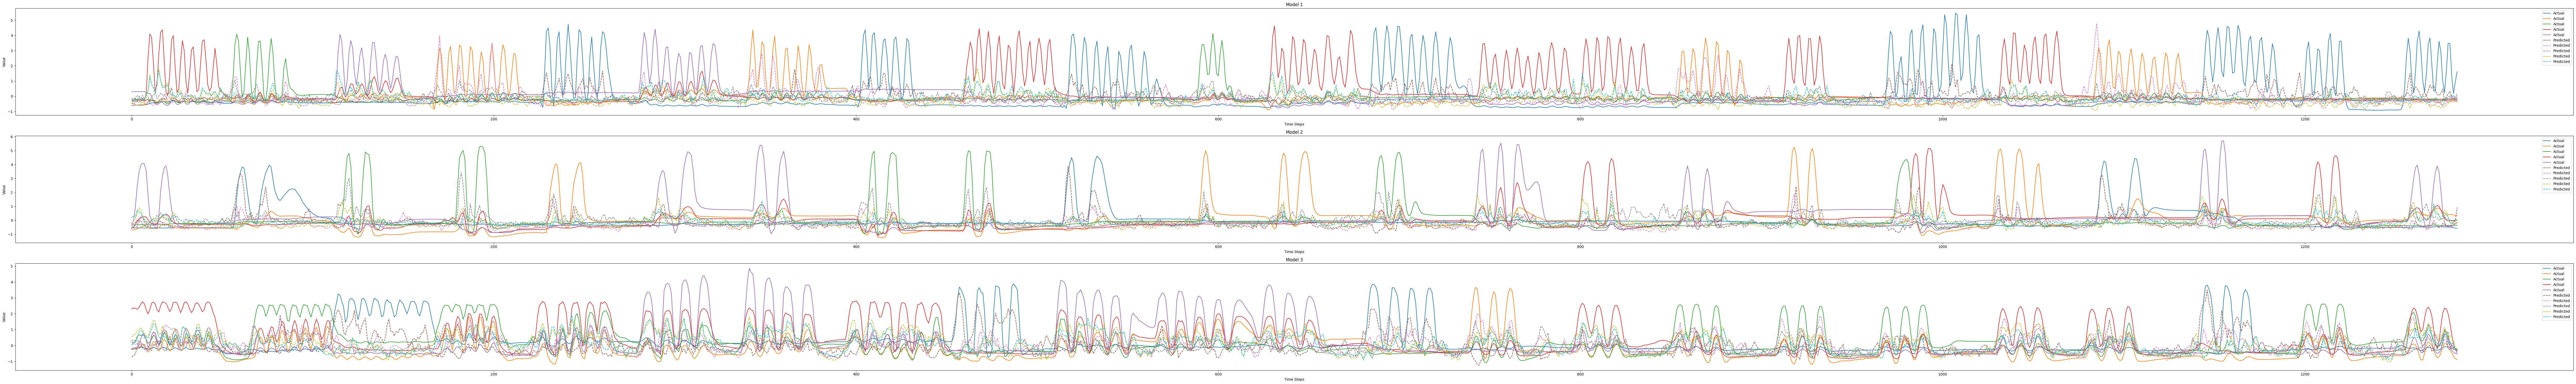

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(100, 15))

# Plot settings
titles = ['Model 1', 'Model 2', 'Model 3']
test_datasets = [test_glove_ds_1, test_glove_ds_2, test_glove_ds_3]
predictions = [cat_preds_1, cat_preds_2, cat_preds_3]
colors = ['blue', 'red', 'yellow']

for i, ax in enumerate(axes.flatten()):
    # Plot the actual data
    ax.plot(test_datasets[i], label='Actual', linestyle='-', marker=None)
    # Plot the predictions
    ax.plot(predictions[i], label='Predicted', linestyle='--', marker=None)
    ax.set_title(titles[i])
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Value')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**LGBoost**

In [ ]:
#(correlations_lgb_1, correlations_lgb_2, correlations_lgb_3)

In [ ]:
!jupyter nbconvert --to html final_project_part_2.ipynb

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'final_project_part_2.ipynb' matched no files
